# Case study 2: differentia-antiphon connections

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import chant21
from music21 import converter # Note: not tested with 6.1 yet!

## 1. CantusCorpus

In [2]:
# We load a demo sample of 2000 randomly selected chants:
CANTUS = 'data/cantuscorpus-v0.2'
chants = pd.read_csv(f'{CANTUS}/csv/chant-demo-sample.csv', index_col=0)

In [3]:
chants.iloc[3, :]

incipit                                        A porta inferi erue domine
cantus_id                                                          001191
mode                                                                    2
finalis                                                               NaN
differentia                                                            D1
siglum                                                           CH-Fco 2
position                                                                4
folio                                                                108r
sequence                                                                3
marginalia                                                            NaN
cao_concordances                                                      NaN
feast_id                                                       feast_1497
genre_id                                                          genre_a
office_id                             

The function `chant21.convertCantusData` directly turns this into a music21 chant (so you don't have to extract the volpiano, text and metadata separately):

In [4]:
ch3 = chant21.convertCantusData(chants.iloc[3, :])
ch3.show('html', showOptions=True)

conversion,"{'originalFormat': 'cantus/volpiano', 'converter': 'chant21', 'version': '0.4.6'}"
incipit,A porta inferi erue domine
cantus_id,001191
mode,2
finalis,nan
differentia,D1
siglum,CH-Fco 2
position,4
folio,108r
sequence,3.0
marginalia,nan


When aligning the text to the music, we keep track of possible misalignments and show these in red. In this case, there are two syllables in the music, and only one syllable in the text:

In [5]:
ch11 = chant21.convertCantusData(chants.iloc[11, :])
ch11.show('html', showOptions=True)

conversion,"{'originalFormat': 'cantus/volpiano', 'converter': 'chant21', 'version': '0.4.6'}"
incipit,Absterget deus omnem lacrimam ab
cantus_id,001212
mode,7
finalis,nan
differentia,*
siglum,D-KA Aug. LX
position,2M
folio,169v
sequence,18.0
marginalia,nan


## 2. Filtering chants

For our case study we will filter out complete chants (not just incipits), with volpiano transcriptions, simple modes (e.g. not transposed), etc. We can do so by quering our `chants` dataframe, and have already implemented several filters in `cantus_filters.py`.

In [6]:
from cantus_filters import *

In [7]:
def filter_antiphons(chants, mode=None):
    print('Filtering chants...')
    opts = dict(logger=lambda msg: print(f' . {msg}'))

    chants = filter_chants_without_volpiano(chants, **opts)
    chants = filter_chants_without_notes(chants, **opts)
    chants = filter_chants_without_simple_mode(chants, include_transposed=False, **opts)
    if mode is not None:
        chants = filter_chants_by_mode(chants, mode=mode, **opts)
    chants = filter_chants_without_full_text(chants, **opts)
    chants = filter_chants_where_incipit_is_full_text(chants, **opts)
    chants = filter_chants_by_genre(chants, include=['genre_a'], **opts)
    chants = filter_chants_not_ending_on_euouae(chants, **opts)

    chants = filter_chants_not_starting_with_G_clef(chants, **opts)
    chants = filter_chants_with_F_clef(chants, **opts)
    chants = filter_chants_with_nonvolpiano_chars(chants, **opts)
    chants = filter_chants_without_word_boundary(chants, **opts)
    return chants

In [8]:
# Okay, antiphons ending on (s)euouae
chants = pd.read_csv(f'{CANTUS}/csv/chant-demo-sample.csv', index_col=0)
chants = filter_antiphons(chants);

Filtering chants...
 . Filter Chants Without Volpiano:
 . Exclude all chants with an empty volpiano field
 .  > 0.00% removed (0 out of 2000; 2000 remain)
 . Filter Chants Without Notes:
 . Exclude all chants without notes
 .  > 3.40% removed (68 out of 2000; 1932 remain)
 . Filter Chants Without Simple Mode:
 . Include only chants with simple modes: 1-8, not transposed
 .  * include_transposed=False
 .  > 22.31% removed (431 out of 1932; 1501 remain)
 . Filter Chants Without Full Text:
 . Filter chants without full text
 .  > 20.39% removed (306 out of 1501; 1195 remain)
 . Filter Chants Where Incipit Is Full Text:
 . Filter chants whose incipit is identical to the full text
 .  > 13.14% removed (157 out of 1195; 1038 remain)
 . Filter Chants By Genre:
 . Include only chants with a certain genre
 .  * include=['genre_a']
 .  > 53.18% removed (552 out of 1038; 486 remain)
 . Filter Chants Not Ending On Euouae:
 . Exclude all chants that don't end on variants of EUOUAE
 .  > 54.53% remo

In [9]:
ch = chant21.convertCantusData(chants.iloc[10, :])
ch.show('html')

conversion,"{'originalFormat': 'cantus/volpiano', 'converter': 'chant21', 'version': '0.4.6'}"
incipit,Aqua quam ego dedero qui
cantus_id,001469
mode,8
finalis,nan
differentia,C1
siglum,CDN-Hsmu M2149.L4
position,M
folio,095v
sequence,6.0
marginalia,nan


## 3. Extract connections

In [10]:
def extract_connection(ch):
    antiphon = ch.sections[0]
    differentia = ch.sections[-1]
    opening = [n.pitch.ps for n in antiphon.flat.notes[:6]]
    ending = [n.pitch.ps for n in differentia.flat.notes[:6]]
    connection = np.asarray(ending + opening)
    return connection

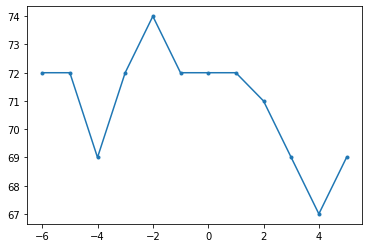

In [11]:
ch = chant21.convertCantusData(chants.iloc[10, :])
positions = np.arange(-6, 6)
connection = extract_connection(ch)
plt.plot(positions, connection, '.-')

And now repeat this for all chants:

In [12]:
def extract_connections(chants):
    connections = []
    for idx, chant_data in chants.iterrows():
        try:
            chant = chant21.convertCantusData(chant_data)
        except:
            print(f'Skipping {idx}')
        conn = extract_connection(chant)
        connections.append(conn)
    return np.asarray(connections)

In [13]:
chants = pd.read_csv(f'{CANTUS}/csv/chant-demo-sample.csv', index_col=0)
chants = filter_antiphons(chants)
connections = extract_connections(chants)

Filtering chants...
 . Filter Chants Without Volpiano:
 . Exclude all chants with an empty volpiano field
 .  > 0.00% removed (0 out of 2000; 2000 remain)
 . Filter Chants Without Notes:
 . Exclude all chants without notes
 .  > 3.40% removed (68 out of 2000; 1932 remain)
 . Filter Chants Without Simple Mode:
 . Include only chants with simple modes: 1-8, not transposed
 .  * include_transposed=False
 .  > 22.31% removed (431 out of 1932; 1501 remain)
 . Filter Chants Without Full Text:
 . Filter chants without full text
 .  > 20.39% removed (306 out of 1501; 1195 remain)
 . Filter Chants Where Incipit Is Full Text:
 . Filter chants whose incipit is identical to the full text
 .  > 13.14% removed (157 out of 1195; 1038 remain)
 . Filter Chants By Genre:
 . Include only chants with a certain genre
 .  * include=['genre_a']
 .  > 53.18% removed (552 out of 1038; 486 remain)
 . Filter Chants Not Ending On Euouae:
 . Exclude all chants that don't end on variants of EUOUAE
 .  > 54.53% remo

## 4. Plot the connections

We jitter the connections vertically so we can actually distinguish overlapping connections.

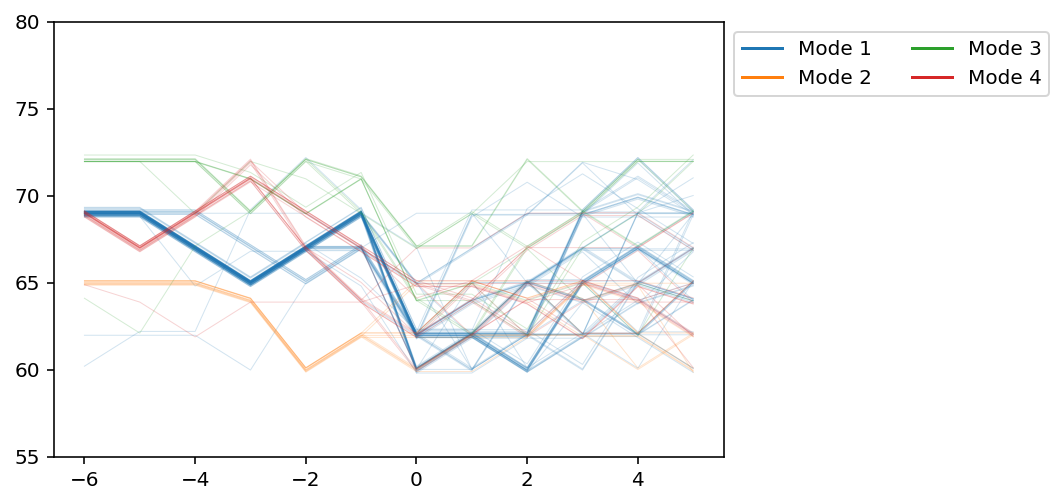

In [14]:
# Plot connections per mode in diff colours
for mode in [1, 2, 3, 4]:
    subset = connections[chants['mode'] == str(mode)]
    jitter = np.random.normal(loc=0, scale=.1, size=len(subset))
    ys = subset + jitter[:, np.newaxis]
    plt.plot(positions, ys.T, '-', 
             alpha=.2, lw=.5, c=f'C{mode-1}')
    plt.plot([0, 0], [0, 0], c=f'C{mode-1}', label=f'Mode {mode}')
    
plt.ylim(55, 80)
plt.legend(ncol=2, bbox_to_anchor=(1,1), loc="upper left")